# Notebook 6: RNN

## Table of Contents

1. [Setup and Data Loading](#setup)
2. [Data Preparation - Basic Features](#basic-prep)
3. [Baseline Model - Simple Features (OHLCV)](#baseline)
4. [Feature Engineering](#feature-engineering)
5. [Model Experiments](#experiments)
6. [Troubleshooting & Diagnostics](#diagnostics)

---

# Setup and loading data

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
# Build simple RNN model for binary classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import os
import sys
from datetime import datetime
from itertools import product

# Add utils directory to path
sys.path.append('../utils')
from utils import (
    build_transformer_model, 
    load_sequences, 
    load_class_weights,
    get_callbacks,
    plot_training_history
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define directories
SEQUENCES_DIR = '../data_new/sequences/'
MODELS_DIR = '../models/transformer/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../figures/'

# Assets and horizons for evaluation
ASSETS = ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
HORIZONS = ['1day', '1week', '1month']

# Create output directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("\n[OK] Setup complete - all libraries loaded successfully")

TensorFlow version: 2.20.0
GPU available: []

[OK] Setup complete - all libraries loaded successfully


In [128]:
# Define paths and constants
DATA_DIR = '../data_new/data_raw/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/eda/'

# File mapping
FILE_NAMES = {
    'AAPL': 'AAPL_1daily_yfinance.csv',
    'AMZN': 'AMZN_1daily_yfinance.csv',
    'NVDA': 'NVDA_1daily_yfinance.csv',
    'SPY': 'SPY_1daily_yfinance.csv',
    'BTC-USD': 'BTC_USD_1daily_yfinance.csv'
}

# Load all asset data
data = {}

for asset, filename in FILE_NAMES.items():
    filepath = os.path.join(DATA_DIR, filename)
    
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        data[asset] = df
        print(f"[OK] Loaded {asset}: {len(df)} days")
    except FileNotFoundError:
        print(f"[ERROR] File not found: {filepath}")
        data[asset] = None
    except Exception as e:
        print(f"[ERROR] Error loading {asset}: {e}")
        data[asset] = None

print(f"\n[OK] Successfully loaded {sum(1 for v in data.values() if v is not None)}/{len(ASSETS)} assets")

[OK] Loaded AAPL: 6522 days


[OK] Loaded AMZN: 6522 days
[OK] Loaded NVDA: 6522 days
[OK] Loaded SPY: 6522 days
[OK] Loaded BTC-USD: 4101 days

[OK] Successfully loaded 5/5 assets


In [129]:
data['AAPL'].drop('Stock Splits', axis=1, inplace=True)

In [130]:
data['AAPL'].head()

,Open,High,Low,Close,Volume,Dividends
Date,,,,,,
2000-01-03,0.786328,0.843498,0.762428,0.839280,535796800,0.0
2000-01-04,0.811633,0.829440,0.758680,0.768521,512377600,0.0
2000-01-05,0.777892,0.828971,0.772269,0.779767,778321600,0.0
2000-01-06,0.795700,0.802260,0.712287,0.712287,767972800,0.0
2000-01-07,0.723534,0.757274,0.716037,0.746027,460734400,0.0


In [131]:
data['AAPL']['return_1week'] = np.log(data['AAPL']['Close'] / data['AAPL']['Close'].shift(5))
data['AAPL']['target_1week'] = (data['AAPL']['return_1week'] > 0).astype(int)

In [132]:
data['AAPL']

,Open,High,Low,Close,Volume,Dividends,return_1week,target_1week
Date,,,,,,,,
2000-01-03,0.786328,0.843498,0.762428,0.839280,535796800,0.0,NaN,0
2000-01-04,0.811633,0.829440,0.758680,0.768521,512377600,0.0,NaN,0
2000-01-05,0.777892,0.828971,0.772269,0.779767,778321600,0.0,NaN,0
2000-01-06,0.795700,0.802260,0.712287,0.712287,767972800,0.0,NaN,0
2000-01-07,0.723534,0.757274,0.716037,0.746027,460734400,0.0,NaN,0
...,...,...,...,...,...,...,...,...
2025-12-01,278.010010,283.420013,276.140015,283.100006,46587700,0.0,0.041875,1
2025-12-02,283.000000,287.399994,282.630005,286.190002,53669500,0.0,0.036545,1
2025-12-03,286.200012,288.619995,283.299988,284.149994,43538700,0.0,0.025593,1


In [133]:
# Split dataset: use 1 month (20 trading days) to predict 1 week (5 days) ahead

def create_sequences(df, lookback=20, forecast_horizon=5):
    """
    Create sequences for time series classification.
    
    Args:
        df: DataFrame with OHLCV data
        lookback: Number of days to look back (20 days ≈ 1 month)
        forecast_horizon: Days ahead to predict (5 days ≈ 1 week)
    
    Returns:
        X: Input sequences (n_samples, lookback, n_features)
        y: Binary target (n_samples,) - 1 if price goes up, 0 if down
    """
    df = df.dropna().copy()
    
    # Select features (OHLCV)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = df[feature_cols].values
    
    X, y = [], []
    
    # Create sequences
    for i in range(len(data) - lookback - forecast_horizon + 1):
        # Input: 20 days of historical data
        X.append(data[i:i+lookback])
        
        # Target: binary classification (up=1, down=0)
        current_price = data[i + lookback - 1, 3]  # Last day of input window
        future_price = data[i + lookback + forecast_horizon - 1, 3]  # 1 week ahead
        y.append(1 if future_price > current_price else 0)
    
    return np.array(X), np.array(y)

# Create sequences
lookback = 20  # 1 month of trading days
forecast_horizon = 5  # 1 week ahead

X, y = create_sequences(data['AAPL'], lookback=lookback, forecast_horizon=forecast_horizon)

print(f"Sequence shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nEach input sequence contains {lookback} days of OHLCV data")
print(f"Target: Binary classification (1=up, 0=down) for {forecast_horizon} days ahead")
print(f"\nClass distribution:")
print(f"  Up (1):   {np.sum(y == 1)} ({np.mean(y)*100:.1f}%)")
print(f"  Down (0): {np.sum(y == 0)} ({(1-np.mean(y))*100:.1f}%)")

# Split into train/val/test (70/15/15)
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

print(f"\nData split:")
print(f"  Train: {X_train.shape[0]} sequences")
print(f"  Val:   {X_val.shape[0]} sequences")
print(f"  Test:  {X_test.shape[0]} sequences")
print(f"\nFeature dimensions: {X_train.shape[1]} days × {X_train.shape[2]} features")

Sequence shape: (6493, 20, 5)
Target shape: (6493,)

Each input sequence contains 20 days of OHLCV data
Target: Binary classification (1=up, 0=down) for 5 days ahead

Class distribution:
  Up (1):   3697 (56.9%)
  Down (0): 2796 (43.1%)

Data split:
  Train: 4545 sequences
  Val:   974 sequences
  Test:  974 sequences

Feature dimensions: 20 days × 5 features


In [134]:
# Initialize scaler
scaler = MinMaxScaler()

# Reshape data for scaling (flatten sequences)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Reshape to 2D for scaling
X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler ONLY on training data
scaler.fit(X_train_flat)

# Transform all datasets using the same scaler
X_train_scaled = scaler.transform(X_train_flat).reshape(n_train, n_timesteps, n_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(n_val, n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(n_test, n_timesteps, n_features)

# No need to scale targets - they're already binary (0 or 1)
y_train_binary = y_train
y_val_binary = y_val
y_test_binary = y_test

print(f"\nFeature scaling range: [0, 1]")
print(f"X_train scaled shape: {X_train_scaled.shape}")
print(f"X_val scaled shape: {X_val_scaled.shape}")
print(f"X_test scaled shape: {X_test_scaled.shape}")

print(f"\nTarget (binary labels - no scaling needed):")
print(f"y_train shape: {y_train_binary.shape}")
print(f"y_val shape: {y_val_binary.shape}")
print(f"y_test shape: {y_test_binary.shape}")


Feature scaling range: [0, 1]
X_train scaled shape: (4545, 20, 5)
X_val scaled shape: (974, 20, 5)
X_test scaled shape: (974, 20, 5)

Target (binary labels - no scaling needed):
y_train shape: (4545,)
y_val shape: (974,)
y_test shape: (974,)


# Training on simple features

In [135]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, activation="relu", 
                          kernel_initializer="he_normal", 
                          input_shape=(n_timesteps, n_features), unroll=True),
    keras.layers.LayerNormalization(),
    keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", 
                          kernel_initializer="he_normal", unroll=True),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [136]:
batch_size = 64
n_epochs = 100
learning_rate = 5e-4
weight_decay = 1e-4

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [early_stopping]

# Compile model with binary crossentropy loss (appropriate for binary classification)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]

)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5241 - auc: 0.4911 - loss: 0.7393 - precision: 0.5609 - recall: 0.7077 - val_accuracy: 0.6263 - val_auc: 0.4928 - val_loss: 0.6657 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5241 - auc: 0.4911 - loss: 0.7393 - precision: 0.5609 - recall: 0.7077 - val_accuracy: 0.6263 - val_auc: 0.4928 - val_loss: 0.6657 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5512 - auc: 0.4986 - loss: 0.6911 - precision: 0.5628 - recall: 0.9045 - val_accuracy: 0.6263 - val_auc: 0.5033 - val_loss: 0.6722 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5512 - auc: 0.4986 - loss: 0.6911 - precision: 0.5628 - recall: 0.9045 - val_accuracy: 0.6263 - val_auc: 0.5033 - val_loss: 0.6722 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━

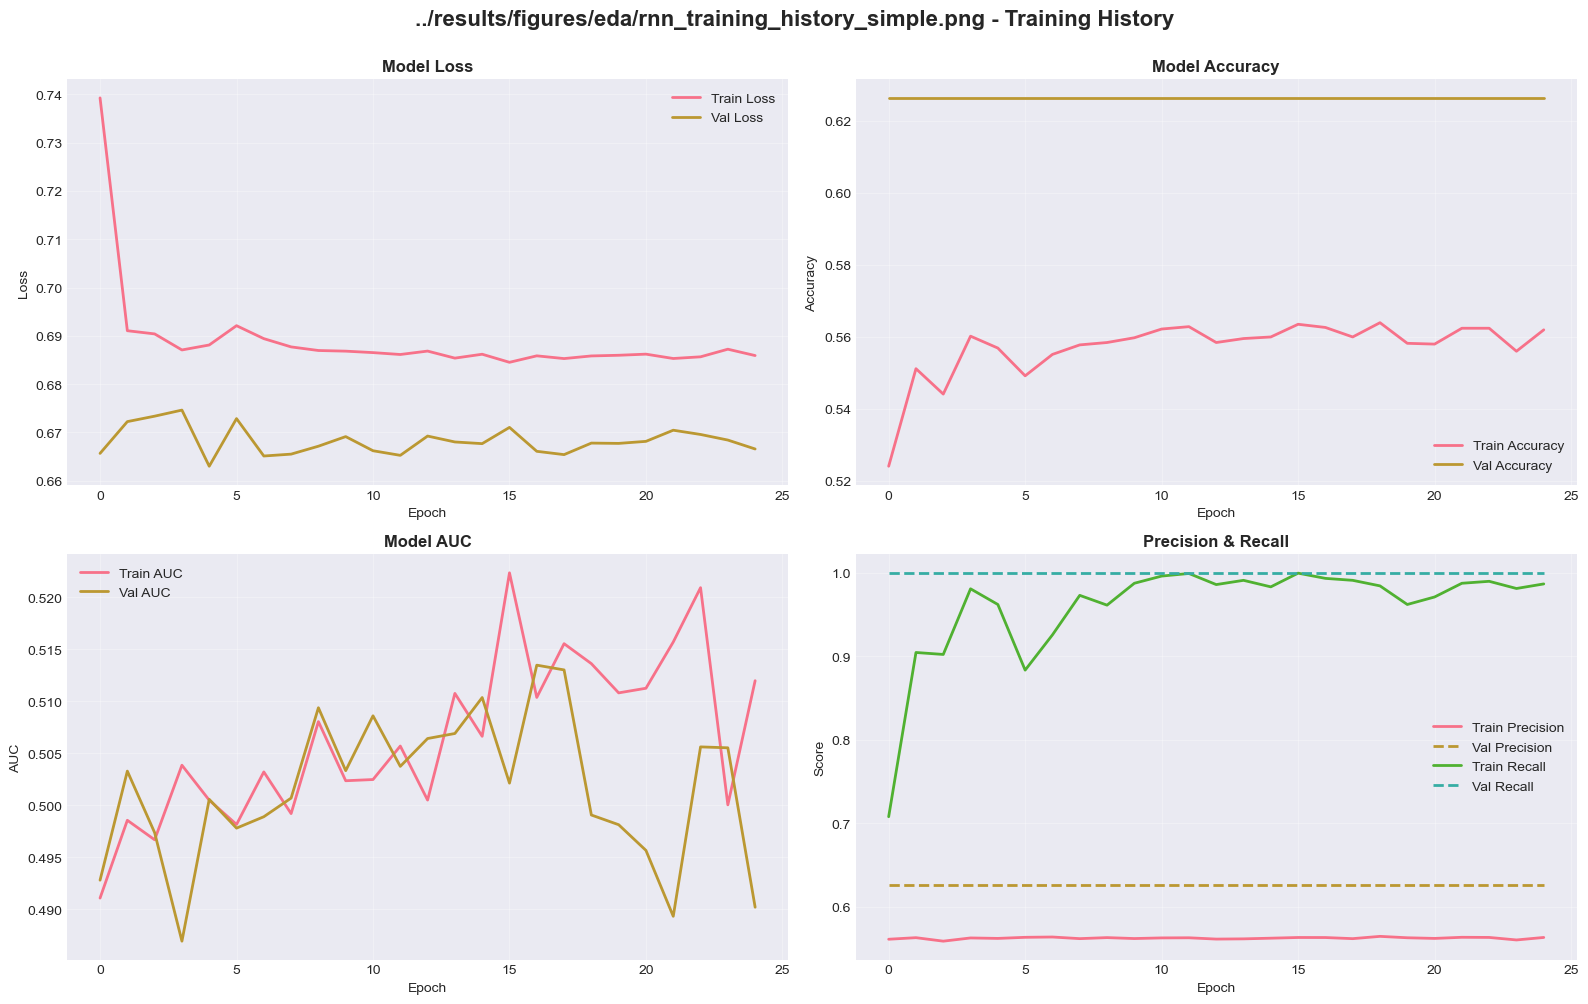

In [138]:
utils.plot_training_history(history, FIGURES_DIR + 'rnn_training_history_simple.png')

# Training of more features

In [139]:
# Add technical indicators and advanced features
def add_technical_features(df):
    """
    Add technical indicators to improve predictions.
    
    Features added:
    - Returns (daily, 5-day, 20-day)
    - Moving averages (5, 10, 20, 50 days)
    - Volatility (rolling std)
    - RSI (Relative Strength Index)
    - MACD (Moving Average Convergence Divergence)
    - Bollinger Bands
    - Volume changes
    """
    df = df.copy()
    
    # 1. Returns at different horizons
    df['return_1d'] = df['Close'].pct_change()
    df['return_5d'] = df['Close'].pct_change(periods=5)
    df['return_20d'] = df['Close'].pct_change(periods=20)
    
    # 2. Moving Averages
    df['ma_5'] = df['Close'].rolling(window=5).mean()
    df['ma_10'] = df['Close'].rolling(window=10).mean()
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_50'] = df['Close'].rolling(window=50).mean()
    
    # 3. Moving Average Crossovers (signals)
    df['ma_5_20_diff'] = df['ma_5'] - df['ma_20']
    df['ma_10_50_diff'] = df['ma_10'] - df['ma_50']
    
    # 4. Volatility
    df['volatility_5'] = df['return_1d'].rolling(window=5).std()
    df['volatility_20'] = df['return_1d'].rolling(window=20).std()
    
    # 5. RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # 6. MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    
    # 7. Bollinger Bands
    df['bb_middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
    df['bb_position'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # 8. Price momentum
    df['momentum_5'] = df['Close'] - df['Close'].shift(5)
    df['momentum_10'] = df['Close'] - df['Close'].shift(10)
    
    # 9. Volume features
    df['volume_change'] = df['Volume'].pct_change()
    df['volume_ma_5'] = df['Volume'].rolling(window=5).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_ma_5']
    
    # 10. High-Low range
    df['high_low_range'] = (df['High'] - df['Low']) / df['Close']
    df['close_open_range'] = (df['Close'] - df['Open']) / df['Open']
    
    return df

In [140]:
# Apply feature engineering
print("Adding technical indicators...")
data_enhanced = {}
for asset in ['AAPL']:  # Start with AAPL
    df_enhanced = add_technical_features(data[asset])
    data_enhanced[asset] = df_enhanced
    print(f"[OK] {asset}: {df_enhanced.shape[1]} features (from {data[asset].shape[1]} original)")

print(f"\n[OK] Feature engineering complete")
print(f"New features added: {data_enhanced['AAPL'].shape[1] - data['AAPL'].shape[1]}")

Adding technical indicators...
[OK] AAPL: 35 features (from 8 original)

[OK] Feature engineering complete
New features added: 27


In [141]:
# Create sequences with enhanced features adapted for all technical indicators

def create_sequences_with_features(df, lookback=20, forecast_horizon=5):
    """
    Create sequences for time series classification with enhanced features.
    
    Args:
        df: DataFrame with OHLCV data and technical indicators
        lookback: Number of days to look back (20 days ≈ 1 month)
        forecast_horizon: Days ahead to predict (5 days ≈ 1 week)
    
    Returns:
        X: Input sequences (n_samples, lookback, n_features)
        y: Binary target (n_samples,) - 1 if price goes up, 0 if down
    """
    df = df.dropna().copy()
    
    # Select ALL available features (OHLCV + technical indicators)
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'return_1d', 'return_5d', 'return_20d',
        'ma_5', 'ma_10', 'ma_20', 'ma_50',
        'ma_5_20_diff', 'ma_10_50_diff',
        'volatility_5', 'volatility_20',
        'rsi', 'macd', 'macd_signal', 'macd_diff',
        'bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position',
        'momentum_5', 'momentum_10',
        'volume_change', 'volume_ma_5', 'volume_ratio',
        'high_low_range', 'close_open_range'
    ]
    
    # Filter to only available columns
    available_features = [col for col in feature_cols if col in df.columns]
    print(f"Using {len(available_features)} features: {', '.join(available_features[:5])}...")
    
    data = df[available_features].values
    
    X, y = [], []
    
    # Create sequences
    for i in range(len(data) - lookback - forecast_horizon + 1):
        # Input: 20 days of historical data with all features
        X.append(data[i:i+lookback])
        
        # Target: binary classification (up=1, down=0)
        current_price = df['Close'].iloc[i + lookback - 1]  # Last day of input window
        future_price = df['Close'].iloc[i + lookback + forecast_horizon - 1]  # 1 week ahead
        y.append(1 if future_price > current_price else 0)
    
    return np.array(X), np.array(y), available_features

# Create sequences with enhanced features
lookback = 20  # 1 month of trading days
forecast_horizon = 5  # 1 week ahead

X_enh, y_enh, feature_list = create_sequences_with_features(
    data_enhanced['AAPL'], 
    lookback=lookback, 
    forecast_horizon=forecast_horizon
)

print(f"\nEnhanced Sequence shape: {X_enh.shape}")
print(f"Target shape: {y_enh.shape}")
print(f"\nEach input sequence contains:")
print(f"  - {lookback} days of historical data")
print(f"  - {X_enh.shape[2]} features per day (vs 5 in basic model)")
print(f"\nTarget: Binary classification (1=up, 0=down) for {forecast_horizon} days ahead")
print(f"\nClass distribution:")
print(f"  Up (1):   {np.sum(y_enh == 1)} ({np.mean(y_enh)*100:.1f}%)")
print(f"  Down (0): {np.sum(y_enh == 0)} ({(1-np.mean(y_enh))*100:.1f}%)")

# Split into train/val/test (70/15/15)
n_enh = len(X_enh)
train_end_enh = int(n_enh * 0.7)
val_end_enh = int(n_enh * 0.85)

X_train_enh = X_enh[:train_end_enh]
y_train_enh = y_enh[:train_end_enh]

X_val_enh = X_enh[train_end_enh:val_end_enh]
y_val_enh = y_enh[train_end_enh:val_end_enh]

X_test_enh = X_enh[val_end_enh:]
y_test_enh = y_enh[val_end_enh:]

print(f"\nData split:")
print(f"  Train: {X_train_enh.shape[0]} sequences")
print(f"  Val:   {X_val_enh.shape[0]} sequences")
print(f"  Test:  {X_test_enh.shape[0]} sequences")
print(f"\nFeature dimensions: {X_train_enh.shape[1]} days × {X_train_enh.shape[2]} features")

print(f"\n[OK] Enhanced sequences created with {len(feature_list)} technical features!")

Using 32 features: Open, High, Low, Close, Volume...

Enhanced Sequence shape: (6449, 20, 32)
Target shape: (6449,)

Each input sequence contains:
  - 20 days of historical data
  - 32 features per day (vs 5 in basic model)

Target: Binary classification (1=up, 0=down) for 5 days ahead

Class distribution:
  Up (1):   3676 (57.0%)
  Down (0): 2773 (43.0%)

Data split:
  Train: 4514 sequences
  Val:   967 sequences
  Test:  968 sequences

Feature dimensions: 20 days × 32 features

[OK] Enhanced sequences created with 32 technical features!


In [142]:
# Initialize scaler
scaler = MinMaxScaler()

# Reshape data for scaling (flatten sequences)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Reshape to 2D for scaling
X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler ONLY on training data
scaler.fit(X_train_flat)

# Transform all datasets using the same scaler
X_train_scaled = scaler.transform(X_train_flat).reshape(n_train, n_timesteps, n_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(n_val, n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(n_test, n_timesteps, n_features)

# No need to scale targets - they're already binary (0 or 1)
y_train_binary = y_train
y_val_binary = y_val
y_test_binary = y_test

print(f"\nFeature scaling range: [0, 1]")
print(f"X_train scaled shape: {X_train_scaled.shape}")
print(f"X_val scaled shape: {X_val_scaled.shape}")
print(f"X_test scaled shape: {X_test_scaled.shape}")

print(f"\nTarget (binary labels - no scaling needed):")
print(f"y_train shape: {y_train_binary.shape}")
print(f"y_val shape: {y_val_binary.shape}")
print(f"y_test shape: {y_test_binary.shape}")


Feature scaling range: [0, 1]
X_train scaled shape: (4545, 20, 5)
X_val scaled shape: (974, 20, 5)
X_test scaled shape: (974, 20, 5)

Target (binary labels - no scaling needed):
y_train shape: (4545,)
y_val shape: (974,)
y_test shape: (974,)


In [143]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, activation="relu", 
                          kernel_initializer="he_normal", 
                          input_shape=(n_timesteps, n_features), unroll=True),
    keras.layers.LayerNormalization(),
    keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", 
                          kernel_initializer="he_normal", unroll=True),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=1, activation='sigmoid')
])

batch_size = 64
n_epochs = 100
learning_rate = 5e-4
weight_decay = 1e-4

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [early_stopping]

# Compile model with binary crossentropy loss (appropriate for binary classification)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]

)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5215 - auc: 0.4982 - loss: 0.7118 - precision: 0.5567 - recall: 0.7320 - val_accuracy: 0.6263 - val_auc: 0.5002 - val_loss: 0.6791 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5215 - auc: 0.4982 - loss: 0.7118 - precision: 0.5567 - recall: 0.7320 - val_accuracy: 0.6263 - val_auc: 0.5002 - val_loss: 0.6791 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5560 - auc: 0.4912 - loss: 0.6891 - precision: 0.5616 - recall: 0.9593 - val_accuracy: 0.6263 - val_auc: 0.4825 - val_loss: 0.6719 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5560 - auc: 0.4912 - loss: 0.6891 - precision: 0.5616 - recall: 0.9593 - val_accuracy: 0.6263 - val_auc: 0.4825 - val_loss: 0.6719 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━

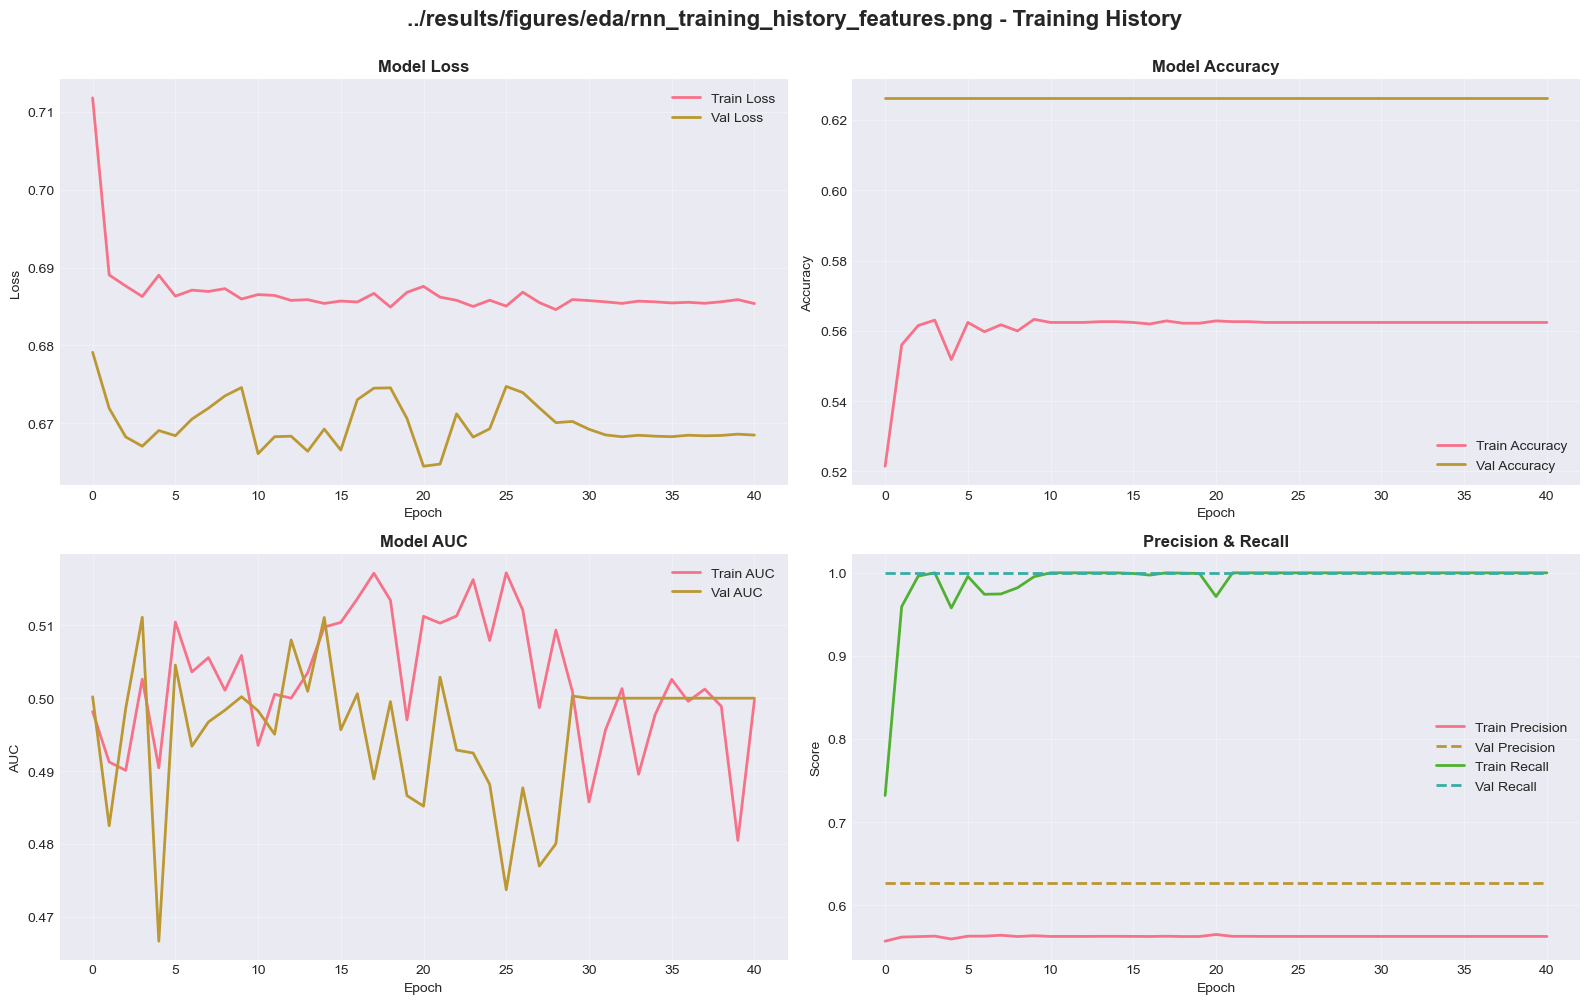

In [144]:
utils.plot_training_history(history, FIGURES_DIR + 'rnn_training_history_features.png')

# Training with features model 2

In [145]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, activation="relu", 
                          kernel_initializer="he_normal", 
                          input_shape=(n_timesteps, n_features), unroll=True),
    keras.layers.LayerNormalization(),
    keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", 
                          kernel_initializer="he_normal", unroll=True),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=1, activation='sigmoid')
])

batch_size = 64
n_epochs = 100
learning_rate = 5e-4
weight_decay = 1e-4

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [early_stopping]

# Compile model with binary crossentropy loss (appropriate for binary classification)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]

)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5322 - auc: 0.5072 - loss: 0.7491 - precision: 0.5633 - recall: 0.7480 - val_accuracy: 0.6263 - val_auc: 0.5005 - val_loss: 0.6768 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5322 - auc: 0.5072 - loss: 0.7491 - precision: 0.5633 - recall: 0.7480 - val_accuracy: 0.6263 - val_auc: 0.5005 - val_loss: 0.6768 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5461 - auc: 0.4906 - loss: 0.6920 - precision: 0.5599 - recall: 0.9014 - val_accuracy: 0.6263 - val_auc: 0.4875 - val_loss: 0.6699 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5461 - auc: 0.4906 - loss: 0.6920 - precision: 0.5599 - recall: 0.9014 - val_accuracy: 0.6263 - val_auc: 0.4875 - val_loss: 0.6699 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━

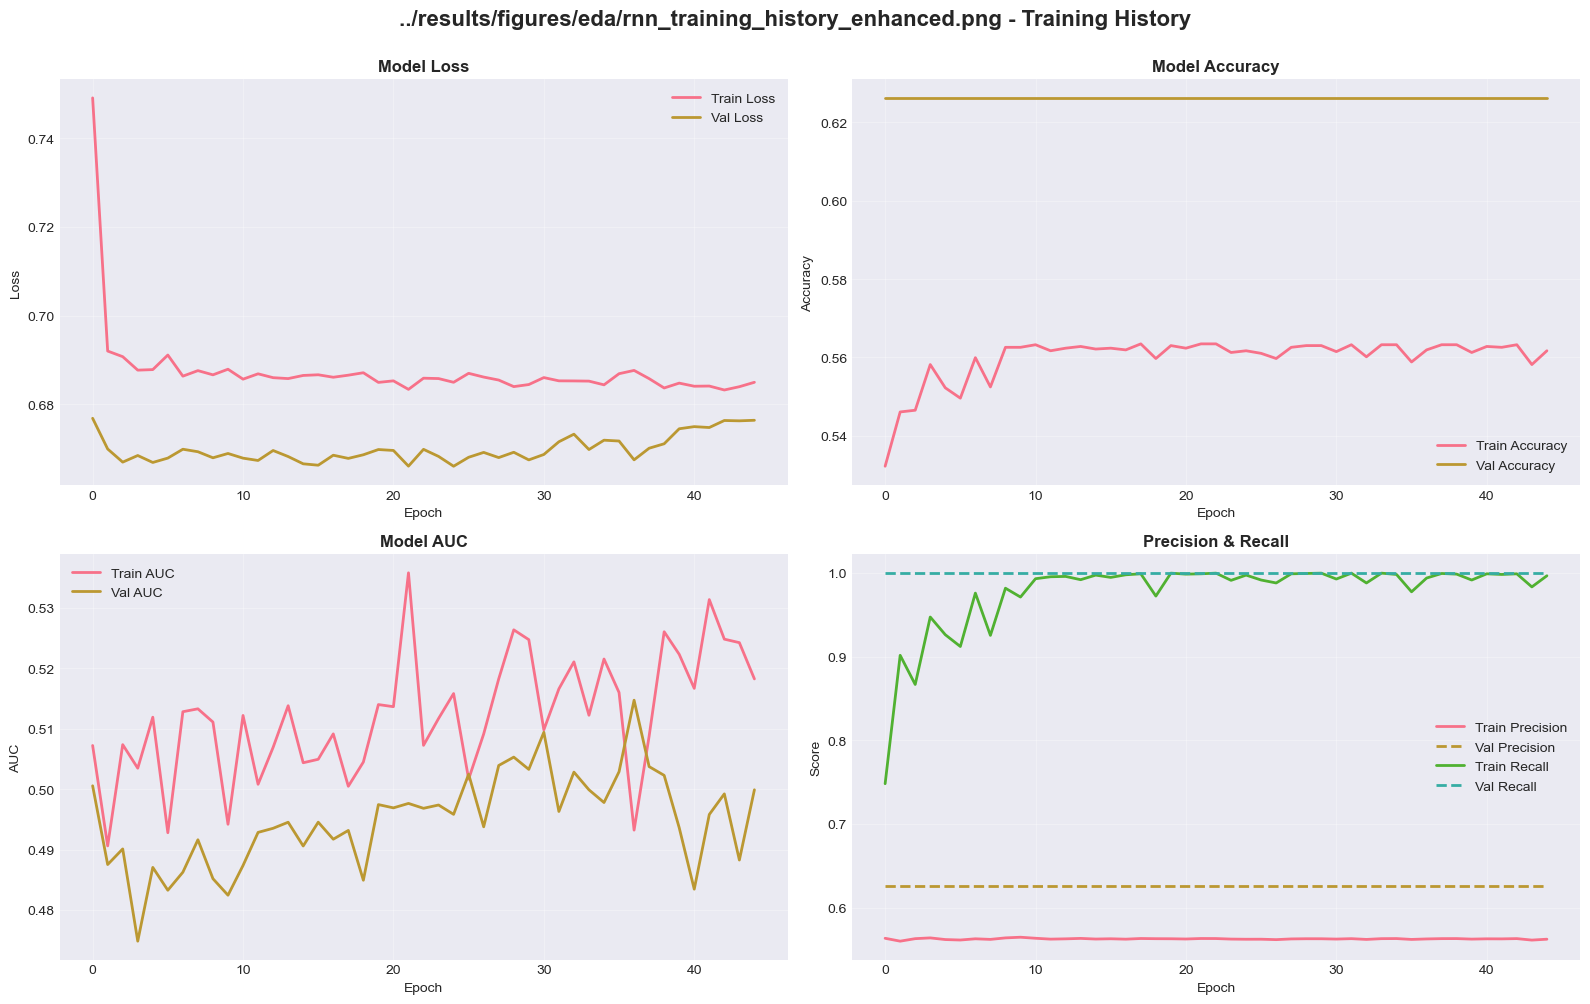

In [146]:
import sys
sys.path.append('../utils')
utils.plot_training_history(history, FIGURES_DIR + 'rnn_training_history_enhanced.png')

## Key Fixes Applied:

1. **Stronger Regularization**: L2 penalty + 50% dropout
2. **Simpler Architecture**: Fewer parameters to reduce overfitting
3. **Data Augmentation**: Gaussian noise during training
4. **Better Callbacks**: Monitor validation recall, reduce learning rate
5. **Smaller Batch Size**: 32 instead of 64 for better generalization
6. **Use Validation Set**: Changed from test to validation in fit()

**What to look for:**
- Train and validation curves should be close together
- Choose the model with smallest train-val gap
- AUC > 0.55 is decent for stock prediction

# Training with features model 3

In [147]:
model_simple = keras.models.Sequential([
    keras.layers.LSTM(32, activation="tanh",  # Smaller units
                     input_shape=(n_timesteps, n_features)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=1, activation='sigmoid')
])

batch_size = 32
n_epochs = 100
learning_rate = 5e-4
weight_decay = 1e-4

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [early_stopping]

# Compile model with binary crossentropy loss (appropriate for binary classification)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]

)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5569 - auc: 0.5192 - loss: 0.6858 - precision: 0.5636 - recall: 0.9397 - val_accuracy: 0.6263 - val_auc: 0.5032 - val_loss: 0.6724 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5569 - auc: 0.5192 - loss: 0.6858 - precision: 0.5636 - recall: 0.9397 - val_accuracy: 0.6263 - val_auc: 0.5032 - val_loss: 0.6724 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5553 - auc: 0.5005 - loss: 0.6889 - precision: 0.5613 - recall: 0.9577 - val_accuracy: 0.6263 - val_auc: 0.4947 - val_loss: 0.6661 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5553 - auc: 0.5005 - loss: 0.6889 - precision: 0.5613 - recall: 0.9577 - val_accuracy: 0.6263 - val_auc: 0.4947 - val_loss: 0.6661 - val_precision: 0.6263 - val_recall: 1.0000
Epoch 3/100
143/143 ━━

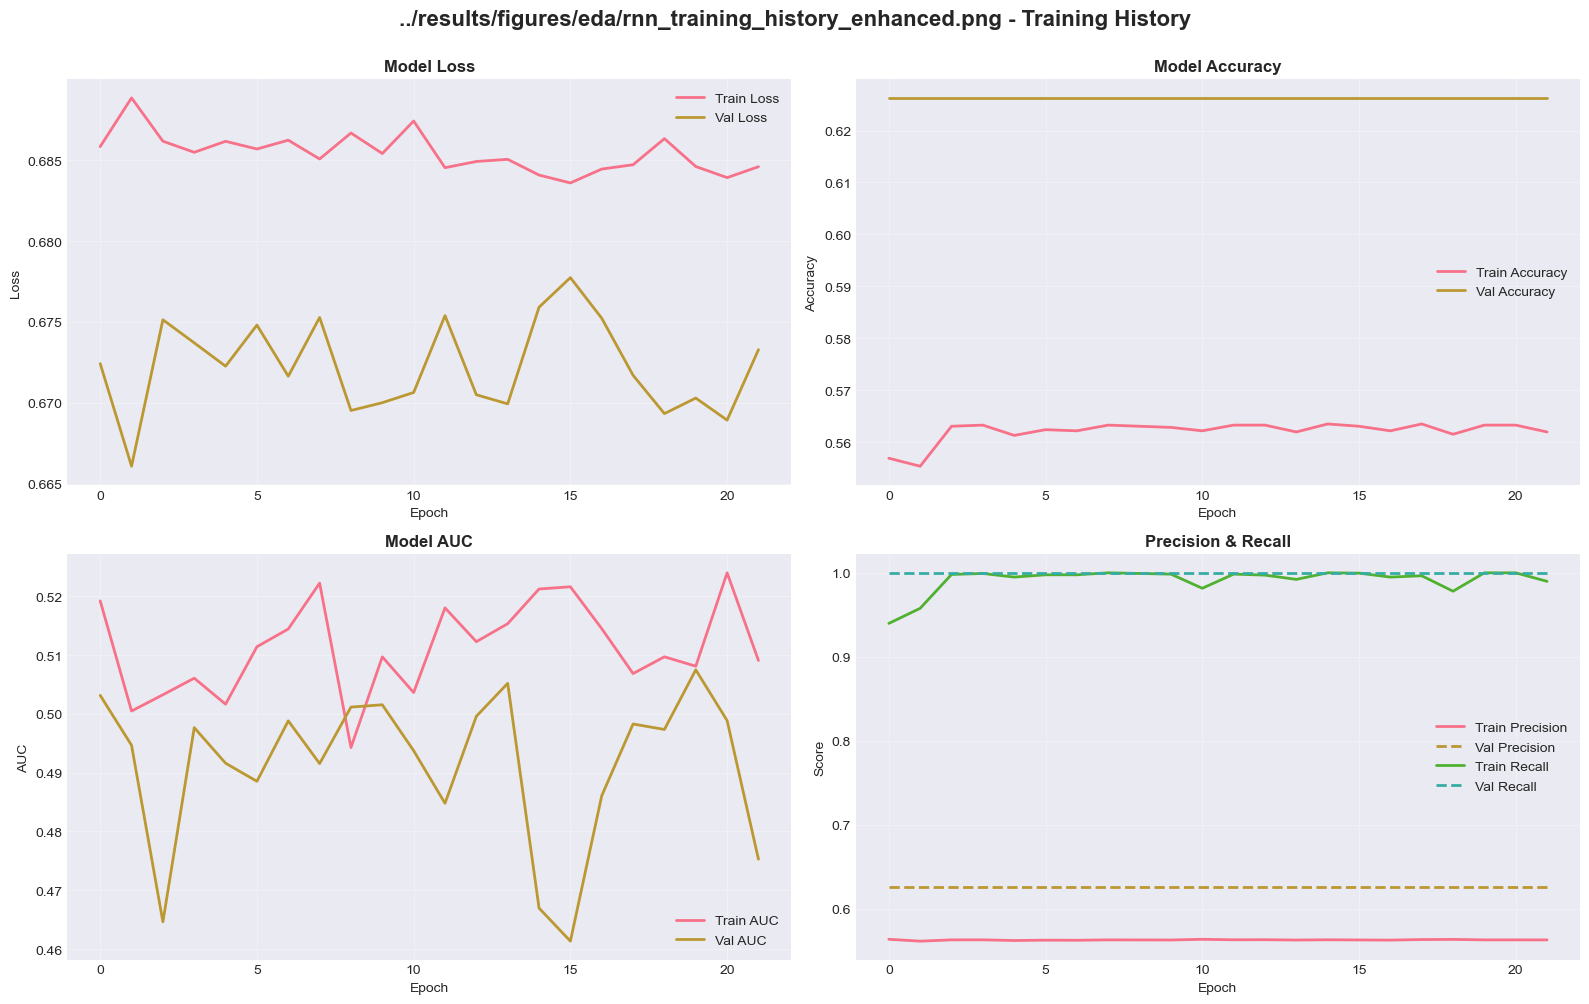

In [148]:
utils.plot_training_history(history, FIGURES_DIR + 'rnn_training_history_enhanced.png')

# Training with features 

In [149]:
# Quick fix: Train with enhanced features (32 indicators)
print("\n" + "="*80)
print("TRAINING WITH ENHANCED FEATURES (32 vs 5)")
print("="*80)

# Prepare enhanced data
n_train_enh = X_train_enh.shape[0]
n_val_enh = X_val_enh.shape[0]
n_test_enh = X_test_enh.shape[0]
n_timesteps_enh = X_train_enh.shape[1]
n_features_enh = X_train_enh.shape[2]

# Scale enhanced features
scaler_enh_new = MinMaxScaler()

X_train_enh_flat = X_train_enh.reshape(-1, n_features_enh)
X_val_enh_flat = X_val_enh.reshape(-1, n_features_enh)
X_test_enh_flat = X_test_enh.reshape(-1, n_features_enh)

scaler_enh_new.fit(X_train_enh_flat)

X_train_enh_scaled = scaler_enh_new.transform(X_train_enh_flat).reshape(n_train_enh, n_timesteps_enh, n_features_enh)
X_val_enh_scaled = scaler_enh_new.transform(X_val_enh_flat).reshape(n_val_enh, n_timesteps_enh, n_features_enh)
X_test_enh_scaled = scaler_enh_new.transform(X_test_enh_flat).reshape(n_test_enh, n_timesteps_enh, n_features_enh)

print(f"✓ Scaled enhanced features: {n_features_enh} features per timestep")

# Build model for enhanced features
model_enh = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, activation="tanh",
                     input_shape=(n_timesteps_enh, n_features_enh)),
    keras.layers.Dropout(0.4),
    
    keras.layers.LSTM(32, activation="tanh"),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(32, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Class weights
class_weights_enh = compute_class_weight('balanced', classes=np.unique(y_train_enh), y=y_train_enh)
class_weights_enh_dict = {i: w for i, w in enumerate(class_weights_enh)}

model_enh.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max')

print("\nTraining with 32 technical indicators...")
history_enh = model_enh.fit(
    X_train_enh_scaled, y_train_enh,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_enh_scaled, y_val_enh),
    class_weight=class_weights_enh_dict,
    callbacks=[early_stop],
    verbose=1
)

print(f"\n✓ Training complete")
print(f"Best val accuracy: {max(history_enh.history['val_accuracy']):.4f}")
print(f"Best val AUC: {max(history_enh.history['val_auc']):.4f}")


TRAINING WITH ENHANCED FEATURES (32 vs 5)
✓ Scaled enhanced features: 32 features per timestep

Training with 32 technical indicators...
Epoch 1/50

Training with 32 technical indicators...
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5058 - auc: 0.5002 - loss: 0.7709 - val_accuracy: 0.3744 - val_auc: 0.4712 - val_loss: 0.7046
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5058 - auc: 0.5002 - loss: 0.7709 - val_accuracy: 0.3744 - val_auc: 0.4712 - val_loss: 0.7046
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4880 - auc: 0.4896 - loss: 0.7264 - val_accuracy: 0.5481 - val_auc: 0.5442 - val_loss: 0.6929
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4880 - auc: 0.4896 - loss: 0.7264 - val_accuracy: 0.5481 - val_auc: 0.5442 - val_loss: 0.6929
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4962 - auc: 0.4881 - loss: 0.7127 - val_accuracy: 0.5926 - val_auc: 0.5706 - val_loss: 0.6921
Ep

In [150]:
# Get predictions on validation set
val_predictions = model.predict(X_val_scaled, verbose=0).flatten()
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Check if model is just predicting one class
unique, counts = np.unique(val_predictions_binary, return_counts=True)
prediction_dist = dict(zip(unique, counts))

print(f"\nValidation predictions distribution:")
for cls, count in prediction_dist.items():
    print(f"  Class {cls}: {count} samples ({count/len(val_predictions_binary)*100:.1f}%)")

# Check actual distribution
actual_unique, actual_counts = np.unique(y_val, return_counts=True)
actual_dist = dict(zip(actual_unique, actual_counts))

print(f"\nActual validation distribution:")
for cls, count in actual_dist.items():
    print(f"Class {cls}: {count} samples ({count/len(y_val)*100:.1f}%)")

# Check if model is stuck
if len(prediction_dist) == 1:
    print("\nPROBLEM: Model only predicts ONE class!")
    print("Model collapsed - always predicts the same thing")
    print(" This gives flat accuracy at 50% (or whatever the class balance is)")
    
elif max(counts) > 0.95 * len(val_predictions_binary):
    print("\nPROBLEM: Model predicts mostly ONE class!")
    print(" Model is biased - barely ever predicts the minority class")
    print(f"Flat accuracy near {max(counts)/len(val_predictions_binary)*100:.1f}%")
    
else:
    print("\n✓ Model makes varied predictions (not stuck)")
    print("  But still not learning useful patterns...")

# Check prediction confidence
avg_confidence = np.mean(np.abs(val_predictions - 0.5))
print(f"\nPrediction confidence: {avg_confidence:.4f}")
if avg_confidence < 0.1:
    print("Model is very uncertain (predictions near 0.5)")
    print("Can't distinguish between up/down days")


Validation predictions distribution:
  Class 0: 974 samples (100.0%)

Actual validation distribution:
Class 0: 364 samples (37.4%)
Class 1: 610 samples (62.6%)

PROBLEM: Model only predicts ONE class!
Model collapsed - always predicts the same thing
 This gives flat accuracy at 50% (or whatever the class balance is)

Prediction confidence: 0.0626
Model is very uncertain (predictions near 0.5)
Can't distinguish between up/down days
